# CLIP Models

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.5.0+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
## The clip package has prepared the model (image encoder and text encoder), the image preprocssing function and text tokenizer for us
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 95.5MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# model.visual  ## image encoder
# model.transformer ## text encoder

In [ ]:
# model.transformer

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7ba36dbe9ea0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

Tokenizing a text is splitting it into words or subwords, and then map them to a sequence of integers, the word indices.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

## Visualize that the CLIP model learns image-text semantic correspondence

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

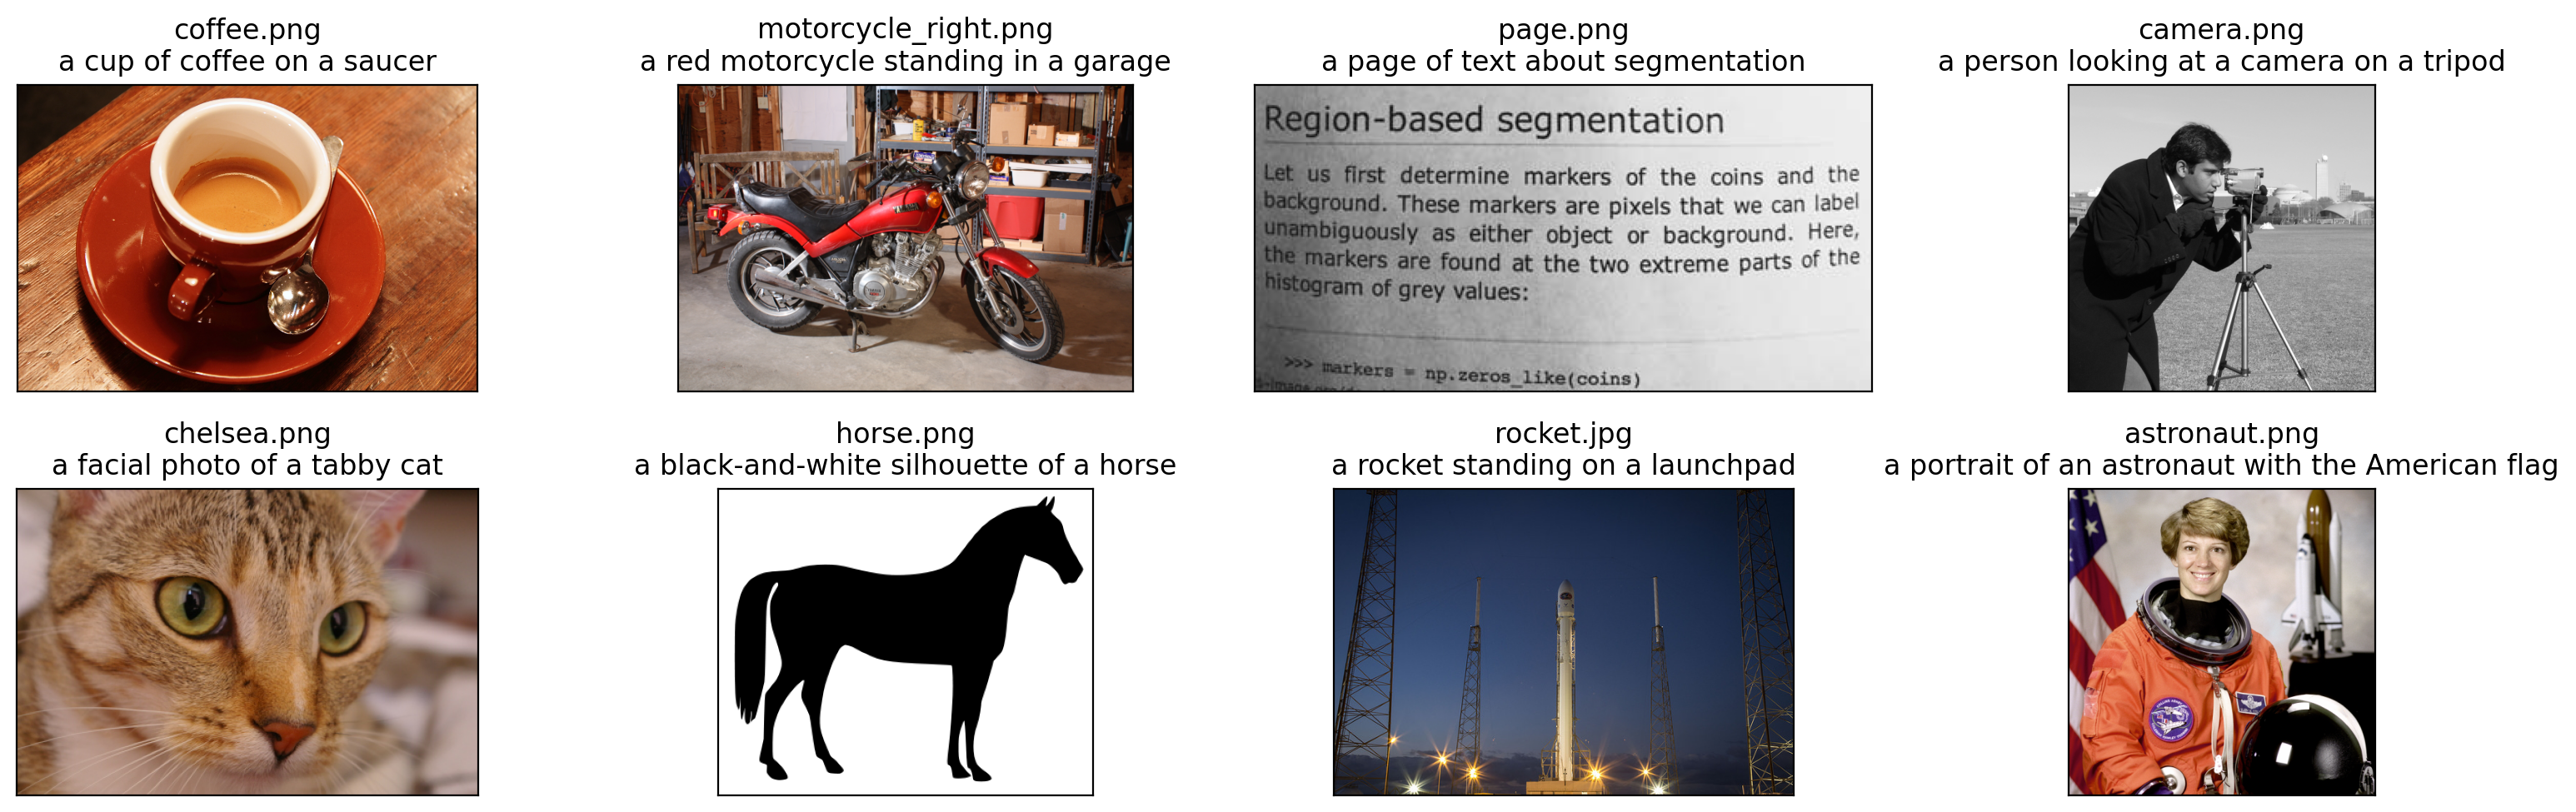

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))
skimage_data_dir=str(skimage.__file__).split('__init__.py')[0]+'/data/'

for filename in [filename for filename in os.listdir(skimage_data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage_data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
## Organize the image in a batch
image_input = torch.tensor(np.stack(images)).cuda()
## Organize the tokenized text in a batch
text_tokens = clip.tokenize([desc for desc in texts]).cuda()

In [ ]:
print(image_input.shape)
print(text_tokens.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 77])


In [ ]:
## with torch.no_grad() - to make sure the model is in the evaluation mode (not update the model parameters)
with torch.no_grad():
    ## encode_image, will call the image encoder to get the image embeddings
    image_features = model.encode_image(image_input).float()
    ## encode_text, will call the text encoder to get the text embeddings
    text_features = model.encode_text(text_tokens).float()

In [ ]:
print(image_features.shape)
print(text_features.shape)

torch.Size([8, 512])
torch.Size([8, 512])


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

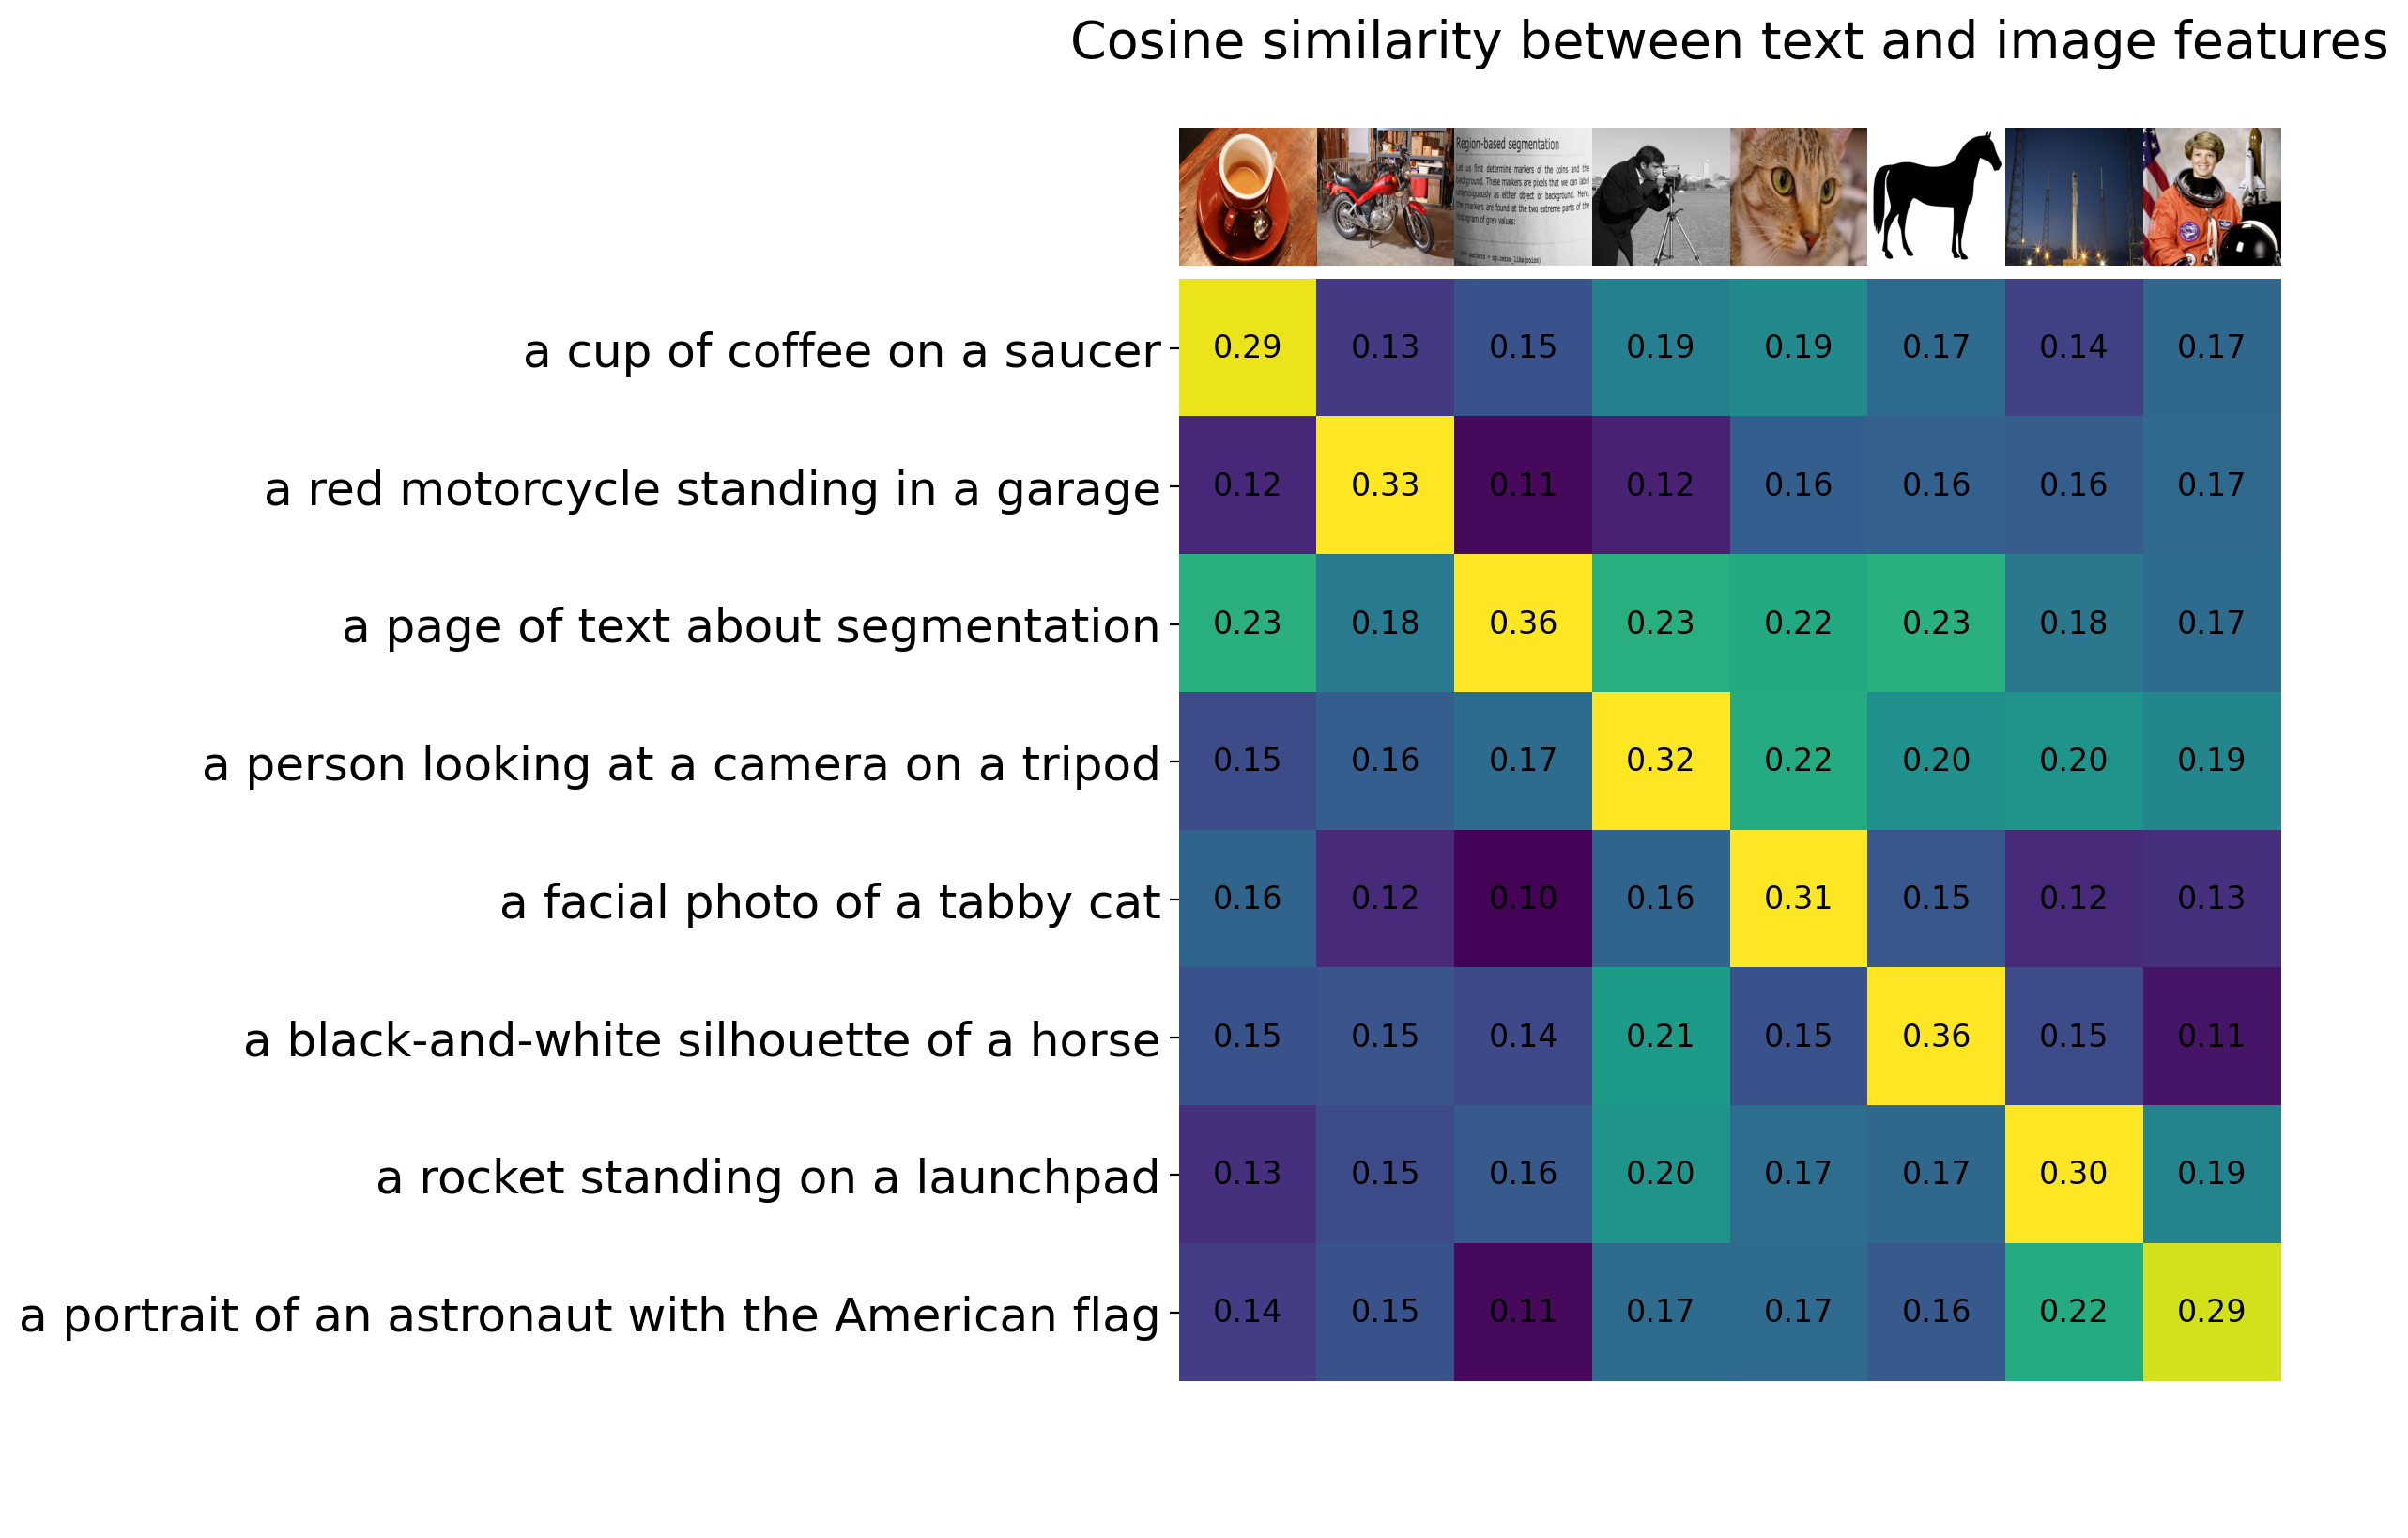

In [ ]:
count = len(descriptions)

plt.figure(figsize=(15, 10))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)




### We can see that CLIP model indeed learn image-text semantic correspondence, that is why we can use it for the zero-shot image classification

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [ ]:
## help prediction to compute the clasification accuracy
def accuracy(predicted,labels):
    predictions, id=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(id==labels).item()/len(predicted))

In [ ]:
# First, build the classification head using the text encoder and class-specific text prompts
# a photo of a {label} --> a photo of an apple
text_descriptions = [f"a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()
print(text_tokens.shape)
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(text_features.shape)

torch.Size([100, 77])
torch.Size([100, 512])


In [ ]:
# text_descriptions

In [ ]:
# Second, set the dataloader for the image dataset
cifar100_testset = CIFAR100(os.path.expanduser("~/.cache"),train=False,download=False,transform=preprocess)
cifar100_test_loader = torch.utils.data.DataLoader(cifar100_testset,batch_size=2000,shuffle=False,pin_memory=True)
print(len(cifar100_test_loader))

5


In [ ]:
# Third, to run the zero-shot classification
accuracy_per_batch=[]
current_epoch=1

for images,labels in cifar100_test_loader:
        print(str(current_epoch)+'/'+str(len(cifar100_test_loader)))
        with torch.no_grad():
            images=images.cuda()
            labels=labels.cuda()
            # get the image embeddings
            image_features = model.encode_image(images).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            print('image_features.shape:'+str(image_features.shape))
            print('text_features.shape:'+str(text_features.shape))
            # multiple the image embeddings with the clasificication head to get the predicted logits
            # [2000, 512] [512, 100] --> [2000, 100]
            # 2000: number of images, 512:embedding size, 100: number of classes
            pred_logits = 100.0 *image_features @ text_features.T
            print('pred_logits.shape:'+str(pred_logits.shape))
            pred_probs=pred_logits.softmax(dim=-1)
            acc_batch=accuracy(pred_probs,labels)
            print('accuracy at this batch:'+str(acc_batch.item()*100)+'%')
            accuracy_per_batch.append(acc_batch)
        current_epoch+=1




1/5
image_features.shape:torch.Size([2000, 512])
text_features.shape:torch.Size([100, 512])
pred_logits.shape:torch.Size([2000, 100])
accuracy at this batch:59.14999842643738%
2/5
image_features.shape:torch.Size([2000, 512])
text_features.shape:torch.Size([100, 512])
pred_logits.shape:torch.Size([2000, 100])
accuracy at this batch:57.349997758865356%
3/5
image_features.shape:torch.Size([2000, 512])
text_features.shape:torch.Size([100, 512])
pred_logits.shape:torch.Size([2000, 100])
accuracy at this batch:57.999998331069946%
4/5
image_features.shape:torch.Size([2000, 512])
text_features.shape:torch.Size([100, 512])
pred_logits.shape:torch.Size([2000, 100])
accuracy at this batch:57.499998807907104%
5/5
image_features.shape:torch.Size([2000, 512])
text_features.shape:torch.Size([100, 512])
pred_logits.shape:torch.Size([2000, 100])
accuracy at this batch:58.99999737739563%


In [ ]:
overall_accuracy=torch.stack(accuracy_per_batch).mean().item()
print('The zero-shot prediction accuracy on the CIFAR100 testing set:')
print(str(overall_accuracy*100)+'%')

The zero-shot prediction accuracy on the CIFAR100 testing set:
58.19999575614929%


# Zero-Shot Image Classification with Ensembling of Prompts

It has been demonstrated that using more than 80 prompt templates for each class in ImageNet significantly enhances the performance of zero-shot image classification compared to using a single prompt template. In HA7, you will explore how to implement the use of multiple prompt templates for zero-shot classification.

https://github.com/openai/CLIP/blob/main/data/prompts.md

https://github.com/openai/CLIP/blob/main/data/prompts.md#cifar100

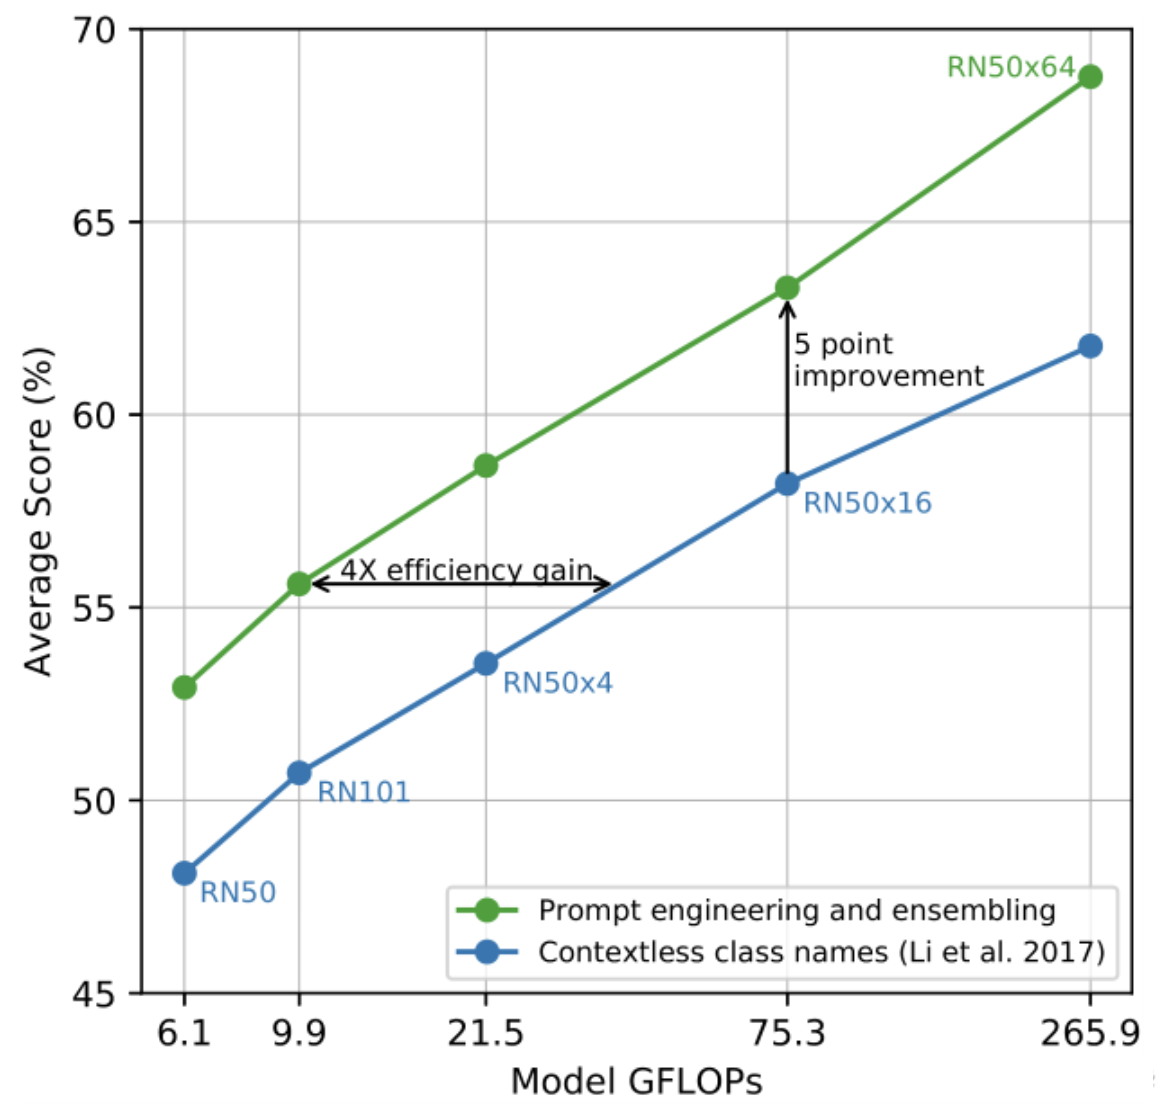

In [ ]:
## Hint: how to implement the use of multiple prompt templates for each class for zero-shot classification.

## Build the classification head using the text encoder and class-specific text prompts

# Now Use one prompt template for each class

'''
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()
print(text_tokens.shape)
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(text_features.shape)
'''

# To use multiple prompt templates for each class, we are essentially using the mean text embeddings of the multiple prompt templates.
# 1. Generate individual text embeddings for each prompt template.
# 2. Calculate the mean of these embeddings.
# 3. Use this mean embedding for classification.

# 'a photo of a {cat}.', 'a good photo of the {cat}.'

# text embedding 1 = encode_text('a photo of a {cat}.')
# text embedding 2 = encode_text('a good photo of the {cat}.')
